In [2]:
import os
import csv
import numpy as np

import time
import datetime

In [3]:
# Image contact time stamps
# all high
# trial 1 2022-03-28 15:06:07.110327
# trial 2 2022-03-28 15:08:35.646496
# all low
# trial 1 2022-03-28 15:12:43.418709
# trial 2 2022-03-28 15:13:38.331845
# one high
# trial 1 2022-03-28 14:43:54.752684
# trial 2 2022-03-28 14:44:51.475726
# one low
# trial 1 2022-03-28 14:46:11.149148
# data for second trial is invalid


gt_data = {
    'all_cam_high_speed': {'trial_1': '2022-03-28 15:06:07.110327', 'trial_2': '2022-03-28 15:08:35.646496'},
    'all_cam_low_speed': {'trial_1': '2022-03-28 15:12:43.418709', 'trial_2': '2022-03-28 15:13:38.331845'},
    'one_cam_high_speed': {'trial_1': '2022-03-28 14:43:54.752684', 'trial_2': '2022-03-28 14:44:51.475726'},
    'one_cam_low_speed': {'trial_1': '2022-03-28 14:46:11.149148'},
}

In [4]:
# helper functions

def str_to_array(string: str):
    return np.array([float(x) for x in string.replace('[', '').replace(']', '').split(';')])


def str_to_timestamp(string: str, format="%d-%m-%Y %H:%M:%S %f"):
    string = string.replace("'", "")
    millisec = string.split(
        '.')[-1] if '.' in string else string.split(' ')[-1]
    return time.mktime(datetime.datetime.strptime(string, format).timetuple()) + float("0." + millisec)


def load_data(path: str):
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        data = []
        for row in reader:
            position = str_to_array(row[1])
            time_stamp = str_to_timestamp(row[3])
            data.append(
                {
                    'pos': position,
                    'time': time_stamp
                }
            )
    return data


def most_frequent(List):
    return max(set(List), key=List.count)

In [97]:
# 'all_cam_high_speed', 'all_cam_low_speed', 'one_cam_high_speed', 'one_cam_low_speed'
current_path = 'one_cam_low_speed'
current_trial = 'trial_1'

path = os.path.join('timesysnc_trials', current_path,
                    current_trial, 'data.csv')

data = load_data(path)

In [29]:
### Currently not used
speed_cut_off_threshold = 2
speed_estimation_steps = 500

def filter_speeds(speeds: list):
    mean = np.mean(speeds, axis=0)
    speeds = list(filter(lambda speed: mean >= speed >= mean/3, speeds))
    mean = most_frequent([int(x) for x in speeds if x > 0])
    low = mean / speed_cut_off_threshold
    high = mean * speed_cut_off_threshold
    print(
        f"Estimated speed values for mean: {mean}, min: {low}, and high: {high}")
    return list(filter(lambda speed: high >= speed >= low, speeds))

def calculate_mean_speed(data : list):
    step_size = int(len(data) / speed_estimation_steps)
    avg_speeds = []
    for i in range(speed_estimation_steps):
        x = data[i * step_size]
        y = data[(i + 1) * step_size - 1]
        speed = abs(np.linalg.norm(x['pos'] - y['pos']) / (x['time'] - y['time']))
        avg_speeds.append(speed)

    avg_speeds = filter_speeds(avg_speeds)
    return np.mean(avg_speeds, axis=0)

def estimate_speed(x: dict, y: dict):
    return abs((x['pos'][2] - y['pos'][2]) / (x['time'] - y['time']))

In [94]:
## function for estimating the time at which vicon no longer publishes gt data
initial_height_estimation_timesteps = 500

def estimate_impact_timestamp(data: list):
    for i, date in enumerate(data):
        height = date['pos'][2]
        if height < 1:
            last_recorded_index = i
            break

    estimation_steps = min(last_recorded_index - 100, initial_height_estimation_timesteps)

    heights = [point['pos'][2] for point in data[:estimation_steps]]
    max_value = max(heights)
    min_value = min(heights)
    max_offset = max_value - min_value
    print(f'Max height difference: {max_value}; min height difference: {min_value}')

    for date in data:
        height = date['pos'][2]
        if height > max_value + max_offset or height < min_value - max_offset:
            print(f'Observed height: {height}')
            return date


In [98]:
print(f'Estimated inaccuracy for {current_path}/{current_trial}')
visual_contact = gt_data[current_path][current_trial]
gt_time_stamp = str_to_timestamp(visual_contact, "%Y-%m-%d %H:%M:%S.%f")

impact_data = estimate_impact_timestamp(data)

mean_speed = calculate_mean_speed(data)

time_diff = gt_time_stamp - impact_data['time']
offset = time_diff * mean_speed

print(f"Estimated vicon observation loss: {impact_data['time']}")
print(f"Visually estimated camera observation loss: {gt_time_stamp}")
print(f"Time difference between observations: {time_diff}s")
print(f"Total estimated offset: {offset}mm")

Estimated inaccuracy for one_cam_low_speed/trial_1
Max height difference: 153.501064565533; min height difference: 152.842852538703
Observed height: 152.15418821769
Estimated speed values for mean: 45, min: 22.5, and high: 90
Estimated vicon observation loss: 1648471570.603
Visually estimated camera observation loss: 1648471571.149148
Time difference between observations: 0.5461480617523193s
Total estimated offset: 25.088883142831186mm


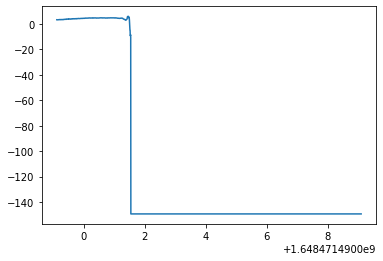

In [96]:
# plot the height data

from matplotlib import pyplot as plt

heights = np.array([date['pos'][2] for date in data])
mean = np.mean(heights[:initial_height_estimation_timesteps], axis=0)
heights -= mean

times = [date['time'] for date in data]

plt.plot(times, heights)